In [1]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift
import random
from matplotlib.colors import ListedColormap


sys.path.append("../..")

from utils.utils import *
from drift_detector.rolling_window import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-08-04 09:17:55,960 INFO cyclops.orm     - Database setup, ready to run queries!


In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
threshold=0.05
num_timesteps = 6
stat_window=60
lookup_window=0
stride=1
run=1
shift="covid"
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH","PMH"]
outcome="mortality"
aggregation_type="time"
scale=True

In [3]:
admin_data, x, y = get_gemini_data(PATH)

numerical_cols = get_numerical_cols(PATH)
for col in numerical_cols:
    scaler = StandardScaler().fit(x[col].values.reshape(-1, 1))
    x[col] = pd.Series(
        np.squeeze(scaler.transform(x[col].values.reshape(-1, 1))),
        index=x[col].index,
    )
X = reshape_inputs(x, num_timesteps)

2022-08-04 09:17:56,033 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-08-04 09:17:56,506 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-08-04 09:17:56,689 INFO cyclops.feature_handler - Loading features from file...
2022-08-04 09:17:56,691 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-04 09:17:56,706 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-04 09:17:56,763 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-08-04 09:18:02,578 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-08-04 09:18:11,365 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet
2022-08-04 09:18:32,848 INFO cyclops.feature_handler - Loading features from file...
2022-08-04 09:18:32,852 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-04 09:18:32,858 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-04 09:18:32,888 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-04 09:18:37,768 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


## Set constant reference distribution

In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, admin_data = import_dataset_hospital(admin_data, x, y, shift, outcome, hospital, run, shuffle=True)

random.seed(1)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, num_timesteps, x_train, y_train, x_val, y_val, x_test, y_test)
# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, num_timesteps, X_tr_normalized, X_val_normalized, X_t_normalized)

## Create Data Streams

In [5]:
start_date = date(2020, 1, 1)
end_date = date(2020, 8, 1)

val_ids=list(X_val_normalized.index.get_level_values(0).unique())

In [6]:
x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1, ids_to_exclude=val_ids)

2020-01-01 - 2020-01-02


## Rolling Window Drift

In [7]:
dr_technique="BBSDs_trained_LSTM"
model_path=os.path.join(os.getcwd(),"../../saved_models/"+shift+"_lstm.pt")
md_test="MMD"
sign_level=0.05
sample=1000
dataset="gemini"
context_type="lstm"
representation="rf"

shift_reductor = ShiftReductor(
    X_tr_final, y_tr, dr_technique, dataset, var_ret=0.8, model_path=model_path,
)
# Get shift detector
shift_detector = ShiftDetector(
    dr_technique, md_test, sign_level, shift_reductor, sample, dataset, feats, model_path, context_type, representation,
)

In [ ]:
dist_test, pvals_test = rolling_window_drift(X_tr_final, x_test_stream, shift_detector, sample, stat_window, lookup_window, stride, num_timesteps, threshold, X_val_final)

## Rolling Window Prediction Performance

In [32]:
from drift_detection.baseline_models.temporal.pytorch.optimizer import Optimizer
from drift_detection.baseline_models.temporal.pytorch.utils import *

output_dim = 1
batch_size = 64
input_dim = 108
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 256
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False

device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
model_path=os.path.join(os.getcwd(),"../../saved_models/"+shift+"_lstm.pt")
model.load_state_dict(torch.load(model_path))
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
activation = nn.Sigmoid()
opt = Optimizer(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    activation=activation,
    lr_scheduler=lr_scheduler,
)

In [56]:
performance_metrics = rolling_window_performance(x_test_stream, y_test_stream, opt, sample, stat_window, lookup_window, stride, num_timesteps, threshold, X_val_final)

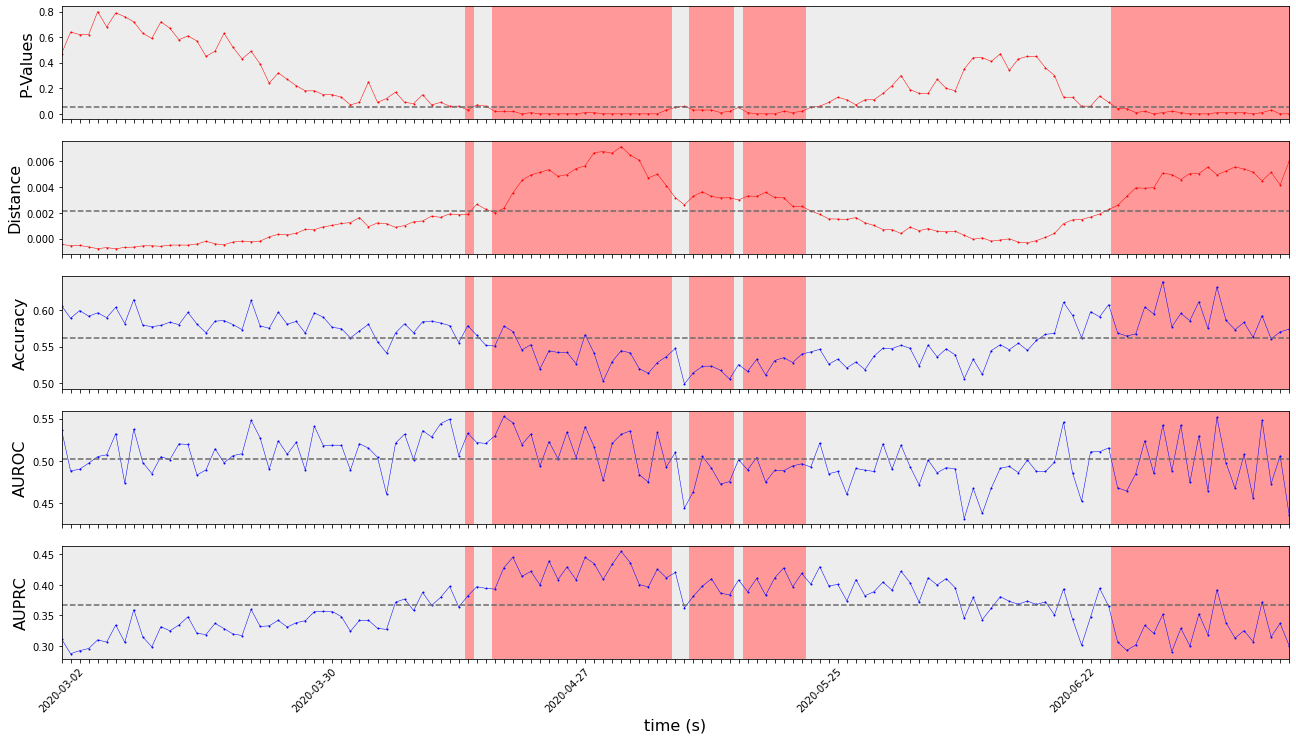

In [75]:
end = performance_metrics.shape[0]
threshold=0.05
measure_dates_test_adjust = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(22,12))
results = pd.DataFrame(
    {'dates': measure_dates_test_adjust[0:end],
     'pval': pvals_test[0:end],
     'dist': dist_test[0:end],
     'detection': np.where(pvals_test[0:end]<threshold,1,0)
    })
results = pd.concat([results,performance_metrics],axis=1)
results.to_pickle(os.path.join(PATH,shift,shift+"_"+dr_technique+"_"+md_test+"_results.pkl")) 
start = 0 
end = performance_metrics.shape[0]-1
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['dates'], results['pval'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['dates'][start], results['dates'][end])
ax1.axhline(y=threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
  
ax2.plot(results['dates'], results['dist'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['dates'][start], results['dates'][end])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['dist']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax3.plot(results['dates'], results['acc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['dates'][start], results['dates'][end])
ax3.set_ylabel('Accuracy', fontsize=16)
ax3.axhline(y=np.mean(results['acc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax4.plot(results['dates'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['dates'][start], results['dates'][end])
ax4.set_ylabel('AUROC', fontsize=16)
ax4.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax5.plot(results['dates'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['dates'][start], results['dates'][end])
ax5.set_ylabel('AUPRC',fontsize=16)
ax5.set_xlabel('time (s)', fontsize=16)
ax5.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax5.tick_params(axis='x', labelrotation=45)
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax5.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()